In [11]:
# 卷积神经网络最初用来处理图片信息，后来扩展到处理文本等其他领域
# 卷积神经网络两个主要操作：卷积和池化，前者过滤得到合理的扫描图，后者扫描子图并计算子图的过滤值。
# 卷积神经网络存在不全（pad）、膨胀（dilate）和步幅（stride）

# 不同维度的卷积：torch.nn.Conv1d, torch.nn.Conv2d, torch.nn.Conv3d
# 不同维度的转置卷积： torch.nn.ConvTranspose1d, torch.nn.ConvTranspose2d, torch.nn.ConvTranspose3d

import torch

# 二维卷积的操作
input = torch.randn(20,16,100,200)
conv = torch.nn.Conv2d(in_channels=16, out_channels=33, kernel_size=(3,3), stride=(2,1), 
                       padding=(4,2), dilation=(3,1))
output = conv(input)
# 50*100 二维张量上进行扫描 （ 50(0) +2pad）/2=26, ( 100(0) +2)/1=102
# 100*200 二维张量上进行扫描 （ 100(0) +2pad）/2=51, (200(0) +2)/1=202
# dilation 空洞卷积， 1表示距离为1，2表示之间差距一个空格，3表示之间差距两个空格
print(output.shape)



torch.Size([20, 33, 51, 202])


In [19]:
# 池化-下采样，反池化-上采样

# 不同维度的最大池化：torch.nn.MaxPool1d, torch.nn.MaxPool2d, torch.nn.MaxPool3d
# 不同维度的自适应最大池化： torch.nn.AdaptiveMaxPool1d, torch.nn.AdaptiveMaxPool2d, torch.nn.AdaptiveMaxPool3d
# 不同维度的平均池化：torch.nn.AvgPool1d, torch.nn.AvgPool2d, torch.nn.AvgPool3d
# 不同维度的l池化： torch.nn.LPPool1d, torch.nn.LPPool2d
# 不同维度的最大反池化：torch.nn.MaxMUnpool1d, torch.nn.MaxUnpool2d, torch.nn.MaxUnpool3d

# 最近邻上采样（维度：1，2，3），线性上采样（维度：linear, bilinear, trilinear）

import torch

# 一维池化
input = torch.tensor([[[1,2,3,4,5]]], dtype=torch.float32)
pool = torch.nn.MaxPool1d(kernel_size=2, stride=2, return_indices=True) # 记住位置，方便后续反池化
output, indices = pool(input) # 最大池化的最大元素对应的原位置信息
print('output:', output)
# max([1,2])=2, max([3,4])=4

# 一维反池化
unpool = torch.nn.MaxUnpool1d(kernel_size=2, stride=2)
input_ = unpool(output, indices) # 恢复那些（除最大元素位置外）其他位置元素为0值，没有上采样
print('input_:', input_)

# 最近邻上采样
upsample = torch.nn.Upsample(scale_factor=2, mode='nearest') # 每个元素重复几倍
input__ = upsample(output) # 恢复那些（除最大元素位置外）其他位置元素为，最近最大元素值
print('input__:', input__)



output: tensor([[[2., 4.]]])
input_: tensor([[[0., 2., 0., 4.]]])
input__: tensor([[[2., 2., 4., 4.]]])


In [27]:
# 补全pad
# 常数补全：torch.nn.ConstantPad2d, torch.nn.ZeroPad2d （指定数字）
# 重复补全：torch.nn.ReplicationPad2d （最后一个元素复制）
# 反射补全：torch.nn.RelectionPad2d, torch.nn.ReflectionPad3d (从最后一个元素开始逆向填充，对称)

import torch

input = torch.tensor([[1,2,3], [4,5,6]], dtype=torch.float32)
print(torch.nn.ConstantPad2d(padding=[1,1,1,1], value=0)(input))
print(torch.nn.ZeroPad2d(padding=[1,1,1,1])(input))
print(torch.nn.ReflectionPad2d(padding=[2,2])(input))


tensor([[0., 0., 0., 0., 0.],
        [0., 1., 2., 3., 0.],
        [0., 4., 5., 6., 0.],
        [0., 0., 0., 0., 0.]])
tensor([[0., 0., 0., 0., 0.],
        [0., 1., 2., 3., 0.],
        [0., 4., 5., 6., 0.],
        [0., 0., 0., 0., 0.]])
tensor([[3., 2., 1., 2., 3., 2., 1.],
        [6., 5., 4., 5., 6., 5., 4.]])


In [37]:
# 基于卷积神经网络的图片分类
# 采用MNIST数据集(28*28像素)

from tqdm import tqdm
import torch
import torchvision.datasets
import torchvision.transforms

# model
class Net(torch.nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv = torch.nn.Sequential(
            torch.nn.Conv2d(1, 64, kernel_size=3, padding=1),
            torch.nn.ReLU(),
            torch.nn.Conv2d(64, 128, kernel_size=3, padding=1),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(stride=2, kernel_size=2))
        self.dense = torch.nn.Sequential(
            torch.nn.Linear(128*14*14, 1024),
            torch.nn.ReLU(),
            torch.nn.Dropout(p=0.5),
            torch.nn.Linear(1024,10),
            torch.nn.Softmax(-1))
    def forward(self, x):
        x1 = self.conv(x)
        x2 = x1.view(-1, 128*14*14)
        return self.dense(x2)

# data
train_data = torchvision.datasets.MNIST('./data/mnist', train=True, transform=torchvision.transforms.ToTensor(),
                                       download=True)
test_data = torchvision.datasets.MNIST('./data/mnist', train=False, transform=torchvision.transforms.ToTensor(),
                                      download=True)
batch_size = 100
train_loader = torch.utils.data.DataLoader(dataset=train_data, batch_size=batch_size)
test_loader = torch.utils.data.DataLoader(dataset=test_data, batch_size=batch_size)
print('train_loader:', len(train_loader))
print('test_loader:', len(test_loader))

net = Net()

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(), lr=0.01)

for step in range(10):
    for idx, (images, labels) in tqdm(enumerate(train_loader)):
        optimizer.zero_grad()
        output = net(images)
        loss = criterion(output, labels)
        if idx==0:
            correct, total = 0, 0
            for images_, labels_ in test_loader:
                output_ = net(images_)
                output__ = torch.argmax(output_, 1)
                total += labels_.size(0)
                correct += (output__==labels_).sum().item()
            print('第{}次迭代第{}批次下：训练损失为{}，测试准确率为{}'.format(step, idx, loss.item(), correct/total))
        loss.backward()
        optimizer.step()


train_loader: 600
test_loader: 100


0it [00:00, ?it/s]

第0次迭代第0批次下：训练损失为2.3026509284973145，测试准确率为0.1128


600it [15:01,  1.50s/it]
0it [00:00, ?it/s]

第1次迭代第0批次下：训练损失为2.331150531768799，测试准确率为0.098


600it [15:14,  1.52s/it]
0it [00:00, ?it/s]

第2次迭代第0批次下：训练损失为2.331150531768799，测试准确率为0.098


600it [15:13,  1.52s/it]
0it [00:00, ?it/s]

第3次迭代第0批次下：训练损失为2.331150531768799，测试准确率为0.098


600it [15:10,  1.52s/it]
0it [00:00, ?it/s]

第4次迭代第0批次下：训练损失为2.331150531768799，测试准确率为0.098


600it [15:32,  1.55s/it]
0it [00:00, ?it/s]

第5次迭代第0批次下：训练损失为2.331150531768799，测试准确率为0.098


600it [15:13,  1.52s/it]
0it [00:00, ?it/s]

第6次迭代第0批次下：训练损失为2.331150531768799，测试准确率为0.098


600it [15:11,  1.52s/it]
0it [00:00, ?it/s]

第7次迭代第0批次下：训练损失为2.331150531768799，测试准确率为0.098


600it [15:21,  1.54s/it]
0it [00:00, ?it/s]

第8次迭代第0批次下：训练损失为2.331150531768799，测试准确率为0.098


600it [15:39,  1.57s/it]
0it [00:00, ?it/s]

第9次迭代第0批次下：训练损失为2.331150531768799，测试准确率为0.098


600it [15:37,  1.56s/it]


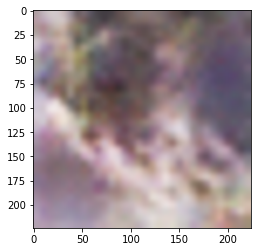

In [5]:
# 读取图片

from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import torch

panda = np.array(Image.open('./data/fake_images/0.png').resize((224, 224)))
panda_tensor = torch.from_numpy(panda)
plt.imshow(panda)


In [ ]:
# 利用register_forward_hook来可视化中间层

from torchvision import models, transforms
import matplotlib.pyplot as plt
from PIL import Image
import torch
from torch.utils.data import DataLoader, Dataset
from torchvision.datasets import ImageFolder

# image = Image.open('./data/fake_images/0.png').resize((224, 224))
# image = np.array(Image.open('./data/fake_images/0.png').resize((224, 224)))
# image_tensor = torch.from_numpy(image)

simple_transform = transforms.Compose([transforms.Resize((224, 224)),
                                       transforms.ToTensor(),
                                       transforms.Normalize([0.485, 0.456, 0.406],
                                                            [0.229, 0.224, 0.225])])
data = ImageFolder("./data/fake_images/", simple_transform)

train = DataLoader(data, batch_size=1,  shuffle=False, num_workers=5)

vggmodel = models.vgg16(pretrained=True)

class LayerActivations():
    features = None
    def __init__(self, model, layer_num):
        self.hook = model[layer_num].register_forward_hook(self.hook_fn)
    def hook_fn(self, module, input, output):
        self.features = output.cpu()
    def remove(self):
        self.hook.remove()

# 可视化第0层
convout = LayerActivations(vggmodel.features, 0)
# out = vggmodel(torch.autograd.Variable(image_tensor))
img = next(iter(train))
out = vggmodel(torch.autograd.Variable(img))

convout.remove()
features = convout.features

ig = plt.figure(figsize=(20, 50))
fig.subplots_adjust(left=0, right=1, bottom=0, top=0.8, hspace=0, wspace=0.2)
for i in range(5):
    ax = fig.add_subplot(12, 5, i+1, xticks=[], yticks=[])
    ax.imshow(out[0][i].detach().numpy(), cmap="gray")
    
plt.show()

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /Users/fubin/.cache/torch/hub/checkpoints/vgg16-397923af.pth


  0%|          | 0.00/528M [00:00<?, ?B/s]